In [1]:
import sys

import matplotlib.pylab as plt
import numpy as np
import PIL.Image as Image
import os

import tensorflow as tf
import tensorflow_hub as hub

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import torch

2025-08-02 22:07:37.312305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-02 22:07:37.312401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-02 22:07:37.313293: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-02 22:07:37.318626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-02 22:07:37.998883: W tensorflow/compiler/tf2

In [2]:
# Import model
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

# Define image shape
IMAGE_SHAPE = (224, 224)

# Configure classifier
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,), trainable=True)
])


# Get labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


2025-08-02 22:07:40.264521: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


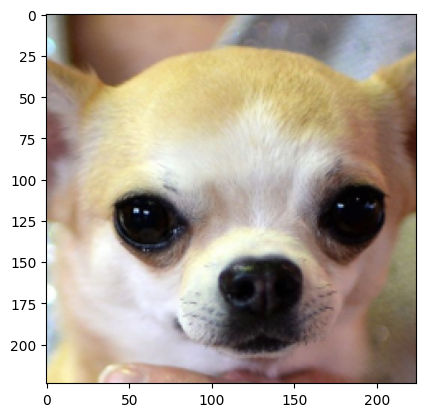

In [3]:
# Load image example
image = Image.open("img/chihuahua.jpg")
image = image.resize(IMAGE_SHAPE)
image = np.array(image)/255.0
image = image[:,:,0:3]
plt.imshow(image)

In [4]:
# Class Prediction example
result = classifier.predict(image[np.newaxis, ...])
predicted_class = np.argmax(result)
print('Class: ' + imagenet_labels[predicted_class])

1/1 [==============================] - 0s 272ms/step
Class: Chihuahua


Number of superpixels: 36


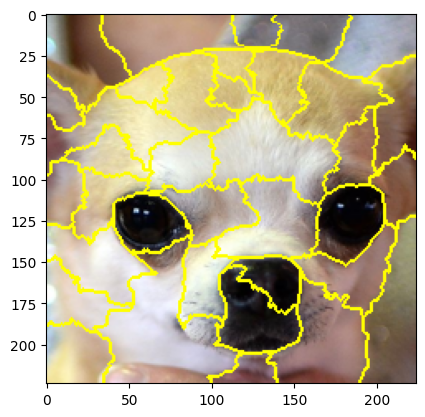

In [5]:
# Create segments

segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)

plt.imshow(mark_boundaries(image, segments))
print("Number of superpixels: " + str(len(np.unique(segments))))

1/1 [==============================] - 0s 40ms/step
French bulldog
CPU times: user 2min 56s, sys: 34 s, total: 3min 30s
Wall time: 45.3 s


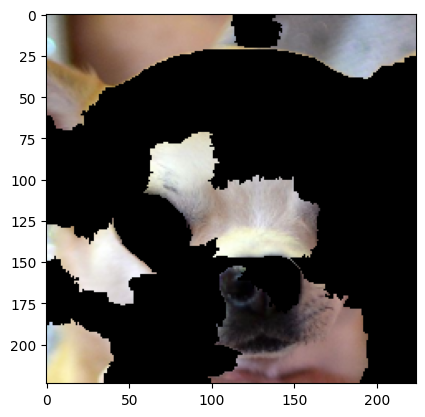

In [6]:
%%time
# CREATE RANDOM CFs - CHANGE UNTIL THE FACTUAL CLASS IS FLIPPED
from isedc.sedc_orig import sedc # SEDC makes that

# Create segments
segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)

# Try to generate CF
explanation, segments_in_explanation, perturbation, new_class = sedc(image, classifier, segments, 'blur')

# Show explanation image 
plt.imshow(explanation)
print(imagenet_labels[new_class])

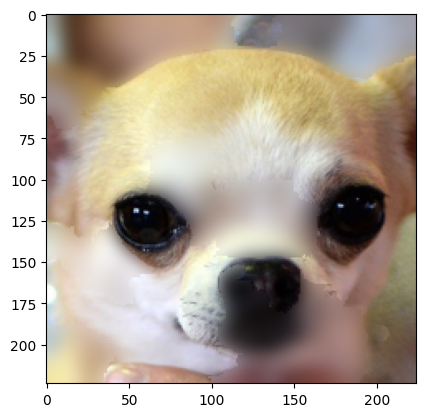

In [7]:
plt.imshow(perturbation)

2/2 [==============================] - 0s 29ms/step
French bulldog
CPU times: user 17.8 s, sys: 19.2 s, total: 37 s
Wall time: 2.07 s


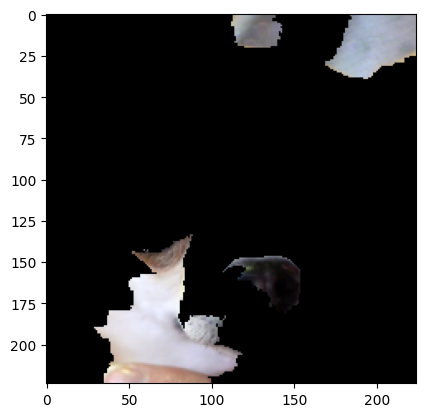

In [12]:
%%time
# CREATE TARGETED CF WITH ORIGINAL, NOT OPTIMIZED, FUNCTION
from isedc.sedc_t2_fastOG import sedc_t2_fast
# Create segments
segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)

# Try to generate CF targeting "French bulldog"
explanation, segments_in_explanation, perturbation, new_class = sedc_t2_fast(
    image, 
    classifier, 
    segments, 
    np.where(imagenet_labels=='French bulldog')[0][0], 
    'random')

# Show explanation image
plt.imshow(explanation)
print(imagenet_labels[new_class])

In [9]:
%%time
# CREATE TARGETED CF WITH OPTIMIZED FUNCTION
from isedc.sedc_t2_fast import sedc_t2_fast

# Create segments
segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)

# Try to generate CF targeting "French bulldog" UNDER 600 SECONDS
explanation, segments_in_explanation, perturbation, new_class = sedc_t2_fast(
    image, 
    classifier, 
    segments, 
    np.where(imagenet_labels=='French bulldog')[0][0], 
    'random', 
    max_time=600)

# Show explanation image
plt.imshow(explanation)
print(imagenet_labels[new_class])

AttributeError: 'numpy.ndarray' object has no attribute 'to'